### Import Libraries

In [ ]:
# Bibliotecas RAPIDS (GPU)
from cuml.preprocessing import StandardScaler
from cuml.pipeline import Pipeline
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.metrics import accuracy_score
from cuml.metrics import confusion_matrix

# Bibliotecas Scikit-learn (CPU)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold 
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler # Necessário para o MLP na CPU/TF
from sklearn.metrics import precision_recall_fscore_support

# Bibliotecas de Utilidades
import optuna
from optuna.samplers import TPESampler
import cupy as cp  # cupy é o "numpy" do RAPIDS
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils

# Bibliotecas TensorFlow
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import gc

# Configuração para não travar a memória da GPU com o TF, permitindo rodar junto com o RAPIDS
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-12-11 21:49:11.222165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Audio Preprocessing

In [2]:
# 1. Carregar os dados oficiais
METADATA_DIR = '../fma_metadata' 
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')
features = utils.load(f'{METADATA_DIR}/features.csv')

# 2. Filtrar pelo dataset 'small'
small_mask = tracks[('set', 'subset')] == 'small'

X_all_pd = features.loc[small_mask] # Deixar como Pandas DataFrame
y_all_labels_pd = tracks.loc[small_mask, ('track', 'genre_top')] # Deixar como Pandas Series
splits = tracks.loc[small_mask, ('set', 'split')]

y_all_labels_pd = y_all_labels_pd.astype(str)

print(f"Total de faixas 'fma_small': {X_all_pd.shape[0]}")
print(f"Total de features: {X_all_pd.shape[1]}")

# 3. EXTRAIR GRUPOS (ARTIST ID) - NOVO
groups_np = tracks.loc[small_mask, ('artist', 'id')].to_numpy()

# 4. Codificar os Gêneros (Labels) - Usando Sklearn
label_encoder = LabelEncoder()
y_all_encoded_np = label_encoder.fit_transform(y_all_labels_pd).astype(np.int32) # Array Numpy

# 5. Converter X para Numpy (para o loop do sklearn)
X_all_np = X_all_pd.to_numpy()

Total de faixas 'fma_small': 8000
Total de features: 518


In [3]:
# Converta para float32 para economizar RAM e VRAM
X_data = X_all_np.astype(np.float32)
y_data = y_all_encoded_np.astype(np.int32)
groups = groups_np

# Definir número de classes
num_classes = len(np.unique(y_data))

### Treino dos Modelos

In [4]:
def build_reference_mlp(input_shape, num_classes):
    l2_reg = 0.002 
    dropout_rate = 0.4
    
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        
        # Camada 1
        layers.Dense(512, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),

        # Camada 2
        layers.Dense(256, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),
        
        # Camada 3
        layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),
        
        # Camada 4
        layers.Dense(64, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        
        # Saída
        layers.Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')
    ])
    
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005) 
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [5]:
# 4. Definir a Estratégia de CV
# Usar StratifiedKFold é ideal para classificação, pois mantém
# a proporção de classes em cada fold (o fma_small é balanceado,
# mas esta é uma boa prática).
n_splits = 10
kf = GroupKFold(n_splits=n_splits)

# 5. Criar Pipelines para os Modelos
# Isso garante que o StandardScaler seja "fitado" apenas nos dados
# de treino de cada fold, e depois "transforma" os dados de treino e teste.

## Pipeline para KNN
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=15)) # Ajuste os hiperparâmetros aqui
])

## Pipeline para SVM
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo')) # Ajuste os hiperparâmetros
])

pipe_rf = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=20)) # Ajuste os hiperparâmetros
])

# Modelo XGBoost
model_xgb = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    tree_method='hist',     # Otimizado para GPU
    device="cuda",          # Usa a RTX 3060
    random_state=42,
    objective='multi:softmax',
    num_class=num_classes 
)

# Dicionário de modelos
models = {
    "KNN (GPU)": pipe_knn,
    "SVM (GPU)": pipe_svm,
    "Random Forest (GPU)": pipe_rf,
    "XGBoost (GPU)": model_xgb,
    "MLP (Keras)": "keras_placeholder" # Marcador para lógica especial
}

# Dicionário para guardar os scores de CADA métrica para cada modelo
# Ex: cv_scores['KNN']['Accuracy'] = [0.5, 0.52, ...]
cv_scores = {}

# Dicionário para guardar as previsões e rótulos de todos os folds,
# para a matriz de confusão final
out_of_fold_preds = {}

# 6. Treinar de Modelos
print(f"Iniciando treinamento com {n_splits} folds...")
print(f"Shape dos dados: {X_all_np.shape}")

debug_feature_selection_flag = True

# --- LOOP DOS MODELOS ---
for model_name, model in models.items():
    print(f"\nIniciando CV 10-Fold para {model_name}...")
    
    fold_scores_acc = []
    fold_scores_precision = []
    fold_scores_recall = []
    fold_scores_f1 = []
    
    all_y_true = []
    all_y_pred = []

    y_pred_fold = None # Variável para guardar as previsões deste fold

    # --- LOOP DOS K-FOLDS ---
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_all_np, y_all_encoded_np, groups=groups_np)):
        # Dados em Numpy (CPU) inicialmente
        X_train, X_test = X_all_np[train_idx], X_all_np[test_idx]
        y_train, y_test = y_all_encoded_np[train_idx], y_all_encoded_np[test_idx]

        # --- SELEÇÃO DE FEATURES COM XGBOOST (GPU) ---
        ## A. Treinar o seletor rápido
        feature_selection_model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            tree_method='hist',
            device="cuda", 
            random_state=42,
            objective='multi:softmax',
            num_class=num_classes,
            verbosity=0
        )
        feature_selection_model.fit(X_train, y_train)

        ## B. Calcular Importâncias
        importances = feature_selection_model.feature_importances_

        ## C. Definir o Limiar
        ## Isso é uma heurística comum: "Seja um pouco melhor que a média para ficar"
        threshold = np.mean(importances) * 1.25 # ...altere esse número para alterar o limiar

        ## Seleciona booleanos onde a importância > threshold
        select_mask = importances > threshold

        ## D. Filtrar
        X_train = X_train[:, select_mask]
        X_test = X_test[:, select_mask]

        # Debug: Mostra quantas features foram selecionadas.
        if debug_feature_selection_flag == True:
            n_selected = np.sum(select_mask)
            print(f"O modelo escolheu automaticamente {n_selected} features relevantes.")

            debug_feature_selection_flag = False
        
        
        # --- TREINO DOS MODELOS ---
        ## 1. MLP (TensorFlow/Keras)
        if model_name == "MLP (Keras)":
            # Scaling na CPU para o TF
            scaler = SklearnStandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Build & Train
            keras_model = build_reference_mlp(X_train.shape[1], num_classes)
            callbacks_list = [
                # Para se o modelo não melhorar por 8 épocas (evita desperdício)
                EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
                
                # Reduz a taxa de aprendizado se o modelo estagnar (O "Pulo do Gato")
                # Se o loss não cair por 3 épocas, divide o LR por 5. 
                # Isso ajuda o modelo a descer o "vale" do mínimo global com passos menores.
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', 
                    factor=0.2, 
                    patience=3, 
                    min_lr=1e-6,
                    verbose=1
                )
            ]

            # Treinamento
            history = keras_model.fit(
                X_train_scaled, y_train,
                epochs=70,
                batch_size=32,
                validation_split=0.1,
                callbacks=callbacks_list,
                verbose=0
            )
            
            # Predict
            y_probs = keras_model.predict(X_test_scaled, verbose=0)
            y_pred_fold = np.argmax(y_probs, axis=1)
            
            # Limpeza Crítica para GPU 6GB
            tf.keras.backend.clear_session()
            del keras_model, X_train_scaled, X_test_scaled
            gc.collect()

        ## 2. Modelos GPU
        elif "(GPU)" in model_name:
            # Converter para CuPy (GPU)
            X_train_cp = cp.array(X_train)
            X_test_cp = cp.array(X_test)
            y_train_cp = cp.array(y_train)
            
            model.fit(X_train_cp, y_train_cp)
            y_pred_cp = model.predict(X_test_cp)
            
            # Trazer de volta para CPU para métricas unificadas depois
            y_pred_fold = cp.asnumpy(y_pred_cp)
            
            # Limpeza
            del X_train_cp, X_test_cp, y_train_cp, y_pred_cp
        
        # Acurácia (cuml accuracy_score aceita numpy e devolve float ou array 0-d)
        acc = accuracy_score(y_test, y_pred_fold)
        fold_scores_acc.append(acc)
        
        # Calculo dos precision_recall_fscore_support
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(y_test, y_pred_fold, average='macro', zero_division=0)
        
        # Converter métricas scalarem de volta para CPU/float para armazenar na lista
        fold_scores_precision.append(float(macro_p))
        fold_scores_recall.append(float(macro_r))
        fold_scores_f1.append(float(macro_f1))
        
        # Acumular para Matriz Final
        all_y_true.append(y_test)
        all_y_pred.append(y_pred_fold)
    
    # Armazenar resultados do modelo
    cv_scores[model_name] = {
        'Acurácia': np.array(fold_scores_acc),
        'Precisão': np.array(fold_scores_precision),
        'Recall': np.array(fold_scores_recall),
        'F1-Score': np.array(fold_scores_f1)
    }
    
    out_of_fold_preds[model_name] = {
        'y_true': np.concatenate(all_y_true),
        'y_pred': np.concatenate(all_y_pred)
    }
    
    # Limpeza final do modelo
    gc.collect()
    cp.get_default_memory_pool().free_all_blocks()

print("\n--- Avaliação Concluída ---")

Iniciando treinamento com 10 folds...
Shape dos dados: (8000, 518)

Iniciando CV 10-Fold para KNN (GPU)...
O modelo escolheu automaticamente 92 features relevantes.

Iniciando CV 10-Fold para SVM (GPU)...

Iniciando CV 10-Fold para Random Forest (GPU)...

Iniciando CV 10-Fold para XGBoost (GPU)...

Iniciando CV 10-Fold para MLP (Keras)...

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 43: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.

Epoch 46: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 40.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 34: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.

Epoch 41: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.

Epoch 44: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 46: early stopping
Restoring model

### Análise de Resultados


========= KNN (GPU) =========
Acurácia       : Média 0.4444 | Std 0.0378
Precisão       : Média 0.4425 | Std 0.0315
Recall         : Média 0.4537 | Std 0.0282
F1-Score       : Média 0.4194 | Std 0.0338

========= SVM (GPU) =========
Acurácia       : Média 0.5301 | Std 0.0418
Precisão       : Média 0.5191 | Std 0.0393
Recall         : Média 0.5332 | Std 0.0397
F1-Score       : Média 0.5164 | Std 0.0405

========= Random Forest (GPU) =========
Acurácia       : Média 0.4922 | Std 0.0392
Precisão       : Média 0.4762 | Std 0.0399
Recall         : Média 0.4974 | Std 0.0374
F1-Score       : Média 0.4738 | Std 0.0393

========= XGBoost (GPU) =========
Acurácia       : Média 0.5246 | Std 0.0416
Precisão       : Média 0.5135 | Std 0.0424
Recall         : Média 0.5266 | Std 0.0400
F1-Score       : Média 0.5115 | Std 0.0424

========= MLP (Keras) =========
Acurácia       : Média 0.5206 | Std 0.0387
Precisão       : Média 0.5041 | Std 0.0410
Recall         : Média 0.5221 | Std 0.0426
F1-Score    

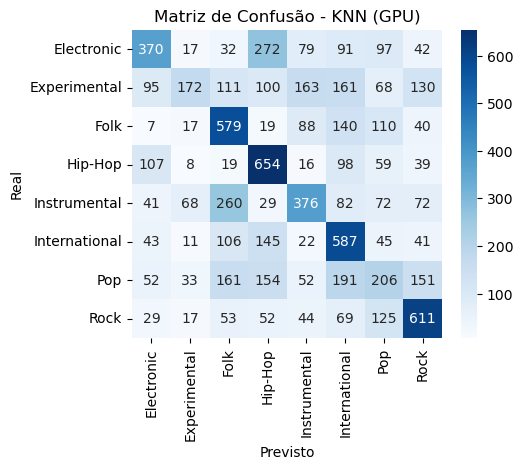

--- SVM (GPU) ---


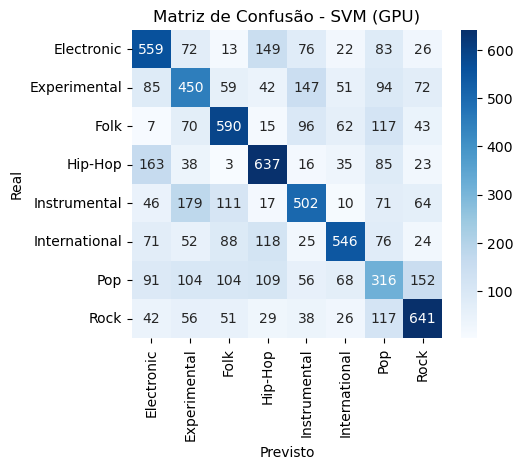

--- Random Forest (GPU) ---


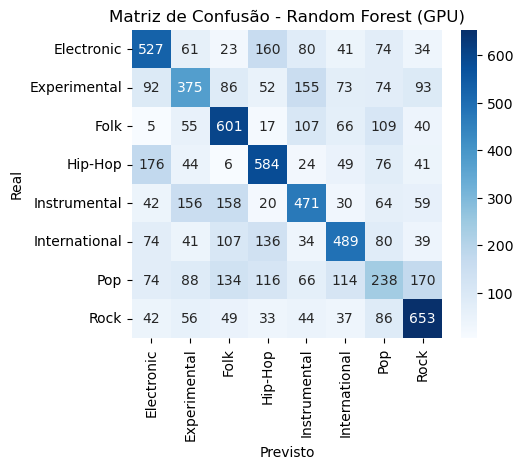

--- XGBoost (GPU) ---


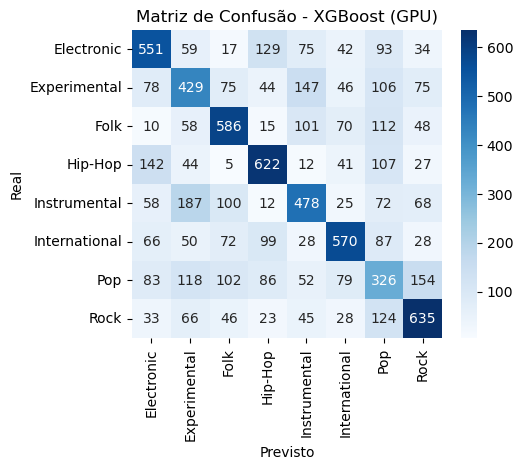

--- MLP (Keras) ---


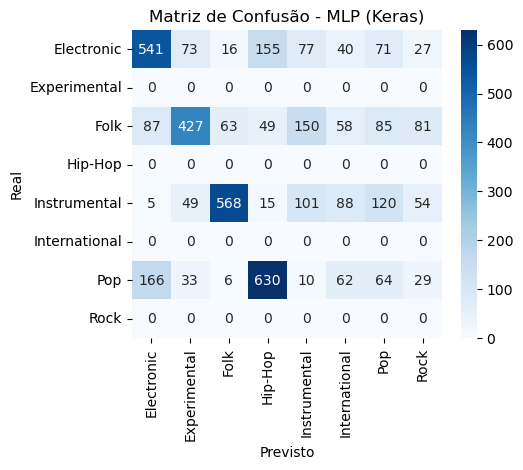

In [6]:
# 4. Exibição dos Resultados
for model_name, metrics in cv_scores.items():
    print(f"\n========= {model_name} =========")
    for metric_name, values in metrics.items():
        print(f"{metric_name:15}: Média {values.mean():.4f} | Std {values.std():.4f}")

# 5. Plot das Matrizes de Confusão
print("\n========= Matrizes de Confusão Agregadas =========")
class_names = label_encoder.classes_ # Nomes dos gêneros

for model_name, results in out_of_fold_preds.items():
    print(f"--- {model_name} ---")
    
    # Calcular CM total usando cuML
    cm_gpu = confusion_matrix(results['y_true'], results['y_pred'])
    cm_cpu = cp.asnumpy(cm_gpu) # Mover para CPU para o Seaborn
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_cpu, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Real')
    plt.xlabel('Previsto')
    plt.show()